# Matching Project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, "../.local/lib/python3.7/site-packages")
import kmeans_radec
from kmeans_radec import KMeans, kmeans_sample

In [2]:
from astropy.coordinates import SkyCoord
import sys
sys.path.insert(0, "../../Assets/FoFCatalogMatching-master")

import FoFCatalogMatching
import GCRCatalogs

In [3]:
# load object catalog (for a single tract)
object_cat = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')

In [4]:
#Make cuts
ra_min, ra_max = 55.0, 56.0
dec_min, dec_max = -29.5, -28.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

# Let's also define a magnitude cut
mag_filters = [
    (np.isfinite, 'mag_i'),
    #'mag_i < 26',
]

In [5]:
###### Load ra and dec from object, using both of the filters we just defined.
object_data = object_cat.get_quantities(['ra', 'dec', 'mag_i_cModel'], filters=(coord_filters + mag_filters), native_filters=['tract == 4850'])

In [6]:
# Let's now turn to the truth catalog
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')

In [7]:
# so we see there is no mag_i, but only mag_true_i (i.e., magnitude before lensing)
# to make our `mag_filters` work, let's define mag_i for the truth catalog
truth_cat.add_quantity_modifier('mag_i', truth_cat.get_quantity_modifier('mag_true_i'))

In [8]:
# get ra and dec from truth catalog
# note that we add i < 24.5 to the native filter to speed up load time
truth_native_filters = (coord_filters) # + ['i < 26'])
truth_data = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'star', 'sprinkled', "i"], filters=mag_filters, native_filters=truth_native_filters)

# We will use the object_id, star, and sprinkled columns when cross-referencing truth information with the extragalactic catalog.

In [9]:
print(truth_data.keys())
print(object_data.keys())
print(truth_data['ra'])

dict_keys(['i', 'ra', 'sprinkled', 'star', 'dec', 'object_id'])
dict_keys(['mag_i_cModel', 'ra', 'dec'])
[55.9289814  55.9252739  55.9451481  ... 55.87876475 55.34440951
 55.16188598]


## Run kmeans on the data

In [10]:
RA_data = np.array(truth_data['ra'])
RA_data = RA_data.reshape((RA_data.shape[0], 1))
DEC_data = np.array(truth_data['dec'])
DEC_data = DEC_data.reshape((DEC_data.shape[0], 1))
tru_data = np.append(RA_data, DEC_data, axis = 1)

In [11]:
#Convert real data to array for use in kmeans_radec
RA_data = np.array(object_data['ra'])
RA_data = RA_data.reshape((RA_data.shape[0], 1))
DEC_data = np.array(object_data['dec'])
DEC_data = DEC_data.reshape((DEC_data.shape[0], 1))
obj_data = np.append(RA_data, DEC_data, axis = 1)

In [13]:
#Run kmeans_radec on the truth data
X = tru_data
# run no more than 100 iterations. Will stop if tolerance is met
ncen = 10
km = kmeans_sample(X, ncen, maxiter=100, tol=1.0e-5)

obj_labels=km.find_nearest(obj_data)
obj_labels.sort()
tru_labels=km.find_nearest(tru_data)
tru_labels.sort()

X (1185, 2)  centers (10, 2)  tol=1e-05  maxiter=100
15 iterations  cluster sizes: [106 110 135 156  89 128 144  82 123 112]
X (351466, 2)  centers (10, 2)  tol=1e-05  maxiter=100
21 iterations  cluster sizes: [34584 34406 46967 34514 30780 35218 42093 24863 39897 28144]


In [14]:
import pandas as pd

In [15]:
panda_truth = pd.DataFrame({"ra":truth_data['ra'],"dec":truth_data['dec'],"labels":tru_labels,"i":truth_data['i']})
panda_object = pd.DataFrame({"ra":object_data['ra'],"dec":object_data['dec'],"labels":obj_labels,"i":object_data['mag_i_cModel']})

In [16]:
print(panda_truth)
print(panda_object)

               ra        dec  labels          i
0       55.928981 -28.578817       0  26.052091
1       55.925274 -28.582050       0  23.451509
2       55.945148 -28.586527       0  23.125852
3       55.934273 -28.565390       0  17.065290
4       55.937526 -28.570538       0  27.093467
...           ...        ...     ...        ...
351461  55.455055 -28.687077       9  29.223406
351462  55.266123 -28.678822       9  32.162210
351463  55.878765 -28.531424       9  31.762485
351464  55.344410 -28.515579       9  32.122260
351465  55.161886 -29.076537       9  32.419726

[351466 rows x 4 columns]
              ra        dec  labels          i
0      55.982535 -29.499981       0  22.870318
1      55.945923 -29.499410       0  24.213295
2      55.954934 -29.498761       0  18.565756
3      55.903585 -29.499185       0  23.179229
4      55.958862 -29.498567       0  20.412199
...          ...        ...     ...        ...
74618  55.008376 -28.639439       9  26.400111
74619  55.056698 -28.

### Now we need to Jackknife the catalogs in preparation for matching.

In [17]:
truth_catalog_list = []
object_catalog_list = []

In [18]:
for i in range(ncen):
    isn = panda_truth["labels"] != i
    filtered = panda_truth[isn]
    truth_catalog_list.append(filtered)

In [19]:
for i in range(ncen):
    isn = panda_object["labels"] != i
    filtered = panda_object[isn]
    object_catalog_list.append(filtered)

In [20]:
print(truth_catalog_list[0])

               ra        dec  labels          i
34584   55.882834 -29.478820       1  22.393165
34585   55.889568 -29.473876       1  24.444511
34586   55.892996 -29.471966       1  26.890209
34587   55.866663 -29.477635       1  27.411515
34588   55.870775 -29.452780       1  28.388716
...           ...        ...     ...        ...
351461  55.455055 -28.687077       9  29.223406
351462  55.266123 -28.678822       9  32.162210
351463  55.878765 -28.531424       9  31.762485
351464  55.344410 -28.515579       9  32.122260
351465  55.161886 -29.076537       9  32.419726

[316882 rows x 4 columns]


### These dictionaries should be compatible with the FoF matching program. Let's try it.

In [21]:
matching_results = []

for i in range(ncen):
    results = FoFCatalogMatching.match(
        catalog_dict={'truth': truth_catalog_list[i], 'object': object_catalog_list[i]},
        linking_lengths=1.0,)
    matching_results.append(results)
    
print(len(matching_results))

10


## Let's begin to analyze.

In [55]:
lost_magnitude_list = []

### Important: To include undetected objects in analysis, edit the cell below.

In [56]:
for results in matching_results:
    truth_mask = results['catalog_key'] == 'truth'
    object_mask = ~truth_mask

    n_groups = results['group_id'].max() + 1
    n_truth = np.bincount(results['group_id'][truth_mask], minlength=n_groups)
    n_object = np.bincount(results['group_id'][object_mask], minlength=n_groups)

    # Let's further inspect the objects in the groups that have 1-to-1 truth/object match.

    # first, let's find our the IDs of the groups that have 1-to-1 truth/object match:
    one_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth == 1) & (n_object == 1)))
    
    '''
    
    The following code REMOVES undetected objects from the analysis.
    
    '''
    multiple_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth >= 2) & (n_object == 1)))
    
    '''
    
    The following code ADDS undetected objects to the analysis. 
    
    '''
    #multiple_to_one_group_mask = np.in1d(results['group_id'], np.flatnonzero((n_truth > n_object)))
    
    
    

    # and then we can find the row indices in the *original* truth/object catalogs for those 1-to-1 groups
    truth_idx = results['row_index'][multiple_to_one_group_mask & truth_mask]
    object_idx = results['row_index'][multiple_to_one_group_mask & object_mask]
    obj_group_id_list = list(results['group_id'][multiple_to_one_group_mask & object_mask])
    truth_group_id_list = list(results['group_id'][multiple_to_one_group_mask & truth_mask])
    truth_ind = list(truth_idx)
    object_ind = list(object_idx)
    
    #Finally, we will find the lost magnitudes for the result. 
    #Store these in a list, which is appended to the lost_magnitude list.
    lost_magnitudes = []
    for i in obj_group_id_list:
        #for every group...

        matched_id_list = [j for j in range(len(truth_group_id_list)) if truth_group_id_list[j] == i]
        #find the matching truth indicies of that group...
        #matched_id_list is a list of list indicies for the given group id.
        #we want to take these and convert them to row_index elements

        truth_indicies = []
        for k in matched_id_list:
            truth_indicies.append(truth_ind[k])
        #convert the matching indicies into catalog indicies...

        #add the lowest magnitudes
        magnitudes = []
        for l in truth_indicies:
            magnitudes.append(truth_data['i'][l])
        #seen_magnitudes.append(np.min(magnitudes))
        del magnitudes[np.argmin(magnitudes)]
        lost_magnitudes += magnitudes
    lost_magnitude_list.append(lost_magnitudes)

In [57]:
print(len(lost_magnitude_list))

10


In [58]:
#Normalize results for ratio plots
bins = 30

l_objects_in_magnitude = []
l_lost_in_magnitude = []
#l_seen_in_magnitude = []

for i in range(len(lost_magnitude_list)):
    lost_mags = lost_magnitude_list[i]
    
    objects_in_magnitude = []
    lost_in_magnitude = []
    seen_in_magnitude = []
    bin_size = (np.max(lost_mags)-np.min(lost_mags))/bins
    bin_min = np.min(lost_mags)

    truth_mag = list(truth_catalog_list[i]['i'])

    for i in range(bins):
        bin_max = bin_min + bin_size
        l = list(x for x in truth_mag if bin_min <= x < bin_max)
        objects_in_magnitude.append(len(l))
        bin_min = bin_max

    bin_min = np.min(lost_mags)
    for i in range(bins):
        bin_max = bin_min + bin_size
        l = list(x for x in lost_mags if bin_min <= x < bin_max)
        lost_in_magnitude.append(len(l))
        bin_min = bin_max

    '''bin_min = 18
    for i in range(bins):
        bin_max = bin_min + bin_size
        l = list(x for x in seen_magnitudes if bin_min <= x < bin_max)
        seen_in_magnitude.append(len(l))
        bin_min = bin_max'''
        
    l_objects_in_magnitude.append(objects_in_magnitude)
    l_lost_in_magnitude.append(lost_in_magnitude)
    #l_seen_in_magnitude.append(seen_in_magnitude)

## Now, all that's left is to calculate error and format for graphing.

In [59]:
bin_list = []
bin_size = (np.max(lost_mags)-np.min(lost_mags))/bins
bin_min = np.min(lost_mags)

for i in range(bins):
    bin_max = bin_min + bin_size
    bin_list.append(bin_min + (.5*bin_size))
    bin_min = bin_max

In [60]:
lost_mag_means = np.sum(l_lost_in_magnitude, axis=0)
lost_mag_means = np.divide(lost_mag_means,ncen)

obj_mag_means = np.sum(l_objects_in_magnitude, axis=0)
obj_mag_means = np.divide(obj_mag_means,ncen)

In [61]:
lost_mag_sd = np.std(l_lost_in_magnitude, axis=0)
lost_mag_sd = np.divide(lost_mag_sd,ncen)

obj_mag_sd = np.std(l_objects_in_magnitude, axis=0)
obj_mag_sd = np.divide(obj_mag_sd,ncen)

In [62]:
#Follow error propagation to find total deviation
total_sd = []
for i in range(len(lost_mag_sd)):
    A = lost_mag_sd[i]/lost_mag_means[i]
    A = A**2
    B = obj_mag_sd[i]/obj_mag_means[i]
    B = B**2
    C = np.sqrt(A+B)
    total_sd.append(C * (lost_mag_means[i] / obj_mag_means[i]))

Text(0, 0.5, 'Proportion of Lost Objects to Total Objects')

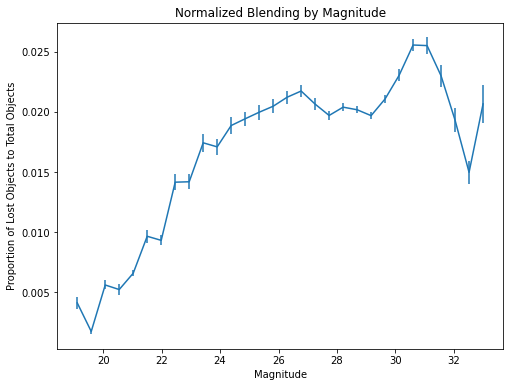

In [63]:
plt.figure(figsize=(8,6))
plt.errorbar(bin_list, np.divide(lost_mag_means,obj_mag_means), total_sd)
plt.title('Normalized Blending by Magnitude')
plt.xlabel('Magnitude')
plt.ylabel('Proportion of Lost Objects to Total Objects')

## The following plots are for diagnostic purposes only.

Text(0.5, 1.0, 'Blending by Magnitude')

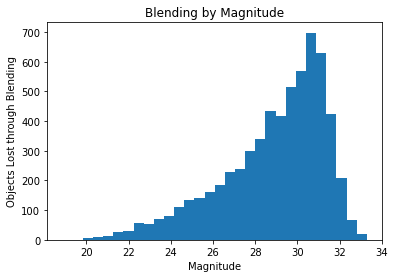

In [50]:
plt.hist(lost_magnitude_list[3], bins=30)
plt.xlabel('Magnitude')
plt.ylabel('Objects Lost through Blending')
plt.title('Blending by Magnitude')

Text(0, 0.5, 'Proportion of Lost Objects')

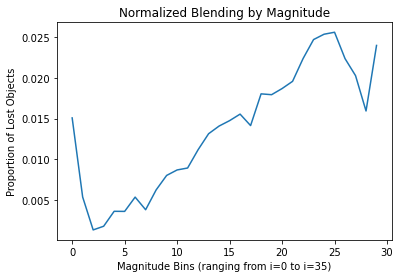

In [51]:
plt.plot(np.divide(l_lost_in_magnitude[0],l_objects_in_magnitude[0]))
plt.title('Normalized Blending by Magnitude')
plt.xlabel('Magnitude Bins (ranging from i=0 to i=35)')
plt.ylabel('Proportion of Lost Objects')

Text(0, 0.5, 'Proportion of Lost Objects')

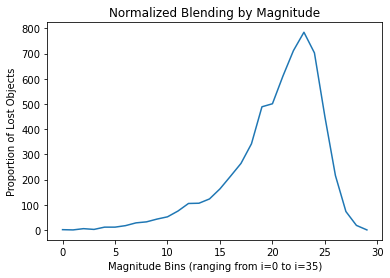

In [52]:
plt.plot(l_lost_in_magnitude[1])
plt.title('Normalized Blending by Magnitude')
plt.xlabel('Magnitude Bins (ranging from i=0 to i=35)')
plt.ylabel('Proportion of Lost Objects')